# Исследование поведения пользователей в мобильном приложении 
# "Ненужные вещи"
**Описание проекта**

Отделу аналитики приложения "Ненужные вещи" поступила задача от продукт-менеджера. Необходимо понять аудиторию приложения, сегментировать пользователей, для этого нам предстоит пронализировать поведение пользователей,- мы должны понять аудиторию, понять сценарии использования приложения

**Цель исследования**
- понять аудиторию приложения,- мы должны понять аудиторию, понять сценарии использования приложения для последующей сегментации пользователей, для этого нам предстоит пронализировать поведение пользователей

**В наличии есть следующие данные**

- `mobile_dataset.csv` - датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений. В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года
- `mobile_sources.csv` - датасет с источниками, с которых пользователь установил приложение

**Задачи исследования**

- выяснить какие сценарии использования приложения выделяются
- проанализировать связь целевого события — просмотра контактов — и других действий пользователей
- выяснить как различается время между поиском и открытием объявления у пользователей, совершающих и не совершающих целевое действие
- проверить статистические гипотезы
 - одни пользователи совершают действия tips_show и tips_click, другие — только tips_show. Проверить гипотезу: конверсия в просмотры контактов различается у этих двух групп
 - пользователи совершающие целевое действие являются более вовлеченными в приложение
 
**Ход исследования**

1. Загрузить файлы с данными и выполнить обзор данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Исследование воронки событий
5. Статистическая проверка гипотез
6. Общий вывод
---

## Файлы с данными и общая информация

In [1]:
import pandas as pd
import datetime
import numpy as np
from scipy import stats as st

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import kaleido
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
# определим свою цветовую гамму для графиков проекта
bam_color = ['#3C6255','#9E6F21', '#A4D0A4'] #, '#EAE7B1', '#CCD5AE', '#617A55', '#FEE8B0', '#B8E7E1']  # палитра цветов
pio.templates['bam'] = go.layout.Template(layout_colorway=bam_color)
pio.templates.default = "plotly_white+bam"

**Загрузим данные о событиях, совершенных в мобильном приложении из CSV-файла в переменные**

In [3]:
logs = pd.read_csv('mobile_dataset.csv')  # логи
sources = pd.read_csv('mobile_sourсes.csv')  # источники

display(logs.head())
sources.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


**Отобразим основную информацию о данных**

In [4]:
display(logs.info())
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


---
### Вывод

**Отобразили начальные строки таблицы и общую информацию**  

**Описание данных**  
В нашем распоряжении два датасета. Файл `mobile_dataset.csv` хранит информацию о логах, где каждая запись это действие пользователя, или событие, `mobile_sourсes.csv` - источники, с которых пользователь установил приложение

Структура `mobile_dataset.csv`:  
- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1`—`search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.
- **Таблица с 3 столбцами(3 строковых) и 74197 строками**

Структура `mobile_sourсes.csv`:
- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.
- **Таблица с 2 столбцами(2 строковых) и 4293 строками**
---

## Предобработка данных

### Заменим названия столбцов

**Приведем к нижнему регистру и к стилю: `слова_разделены_подчёркиванием`**

In [5]:
logs.columns = ['event_time', 'event_name', 'user_id']
sources.columns = ['user_id', 'source']

### Преобразуем данные в нужные типы

**В столбце `logs['event_time']` переведем значения в специальный формат для работы с датами**

In [6]:
logs['event_time'] = pd.to_datetime(logs['event_time'])

### Обработаем пропуски

**Определим количество пропущенных значений в таблице для каждого столбца**

In [7]:
display(logs.isna().sum())
sources.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

user_id    0
source     0
dtype: int64

**Пропусков не обнаружено**

### Обработаем дубликаты

**Выявим явные дубликаты и удалим, если таковые имеются**

In [8]:
for table in [logs, sources]:
    display(table.duplicated().sum())

0

0

- явные дубликаты отсутствуют

**Выявим неявные дубликаты**

Посмотрим какие действия совершают пользователи

In [9]:
logs['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Заменим `show_contacts` на `contacts_show` - это одно и тоже действие

In [10]:
logs['event_name'] = logs['event_name'].replace('show_contacts', 'contacts_show')

Заменим все варианты `search_N` на `search` - это все действия поиска, разделение в нашем исследование не нужно

In [11]:
search = ['search_'+str(i) for i in range(1,8)]

logs['event_name'] = logs['event_name'].replace(search, 'search')

Проверим какие бывают источники привлечения пользователей

In [12]:
sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

Тут все в порядке: 3 источника **yandex, google, other**

### Обработаем редкие и выбивающиеся значения

Такие значения могут быть в столбце `event_time`

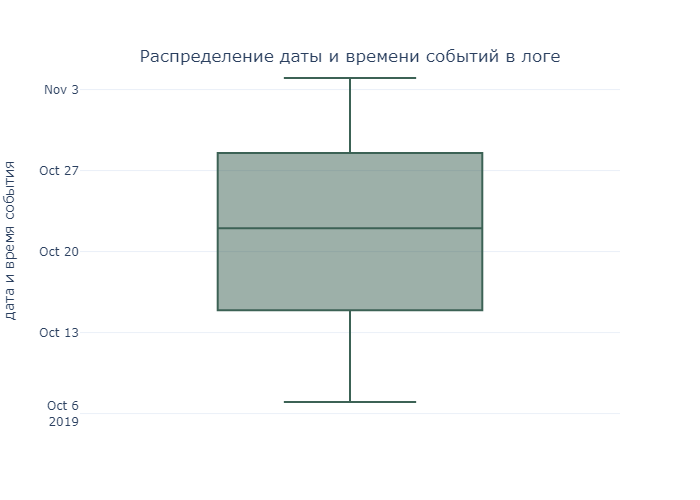

In [13]:
fig = px.box(logs, y="event_time")
fig.update_layout(
        title={
            'text': "Распределение даты и времени событий в логе",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="дата и время события",
    )
fig.show()

- на графике не наблюдаем каких либо выбросов, оставим данные без изменений

### Объединим две таблицы в одну

In [14]:
logs = logs.merge(sources, on='user_id', how='left')

logs.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


- теперь имеем полные данные в одной таблице, так намного удобнее работать в дальнейшем

### Добавим столбец с датой

In [15]:
logs['event_dt'] = logs['event_time'].dt.date

### Отсортируем датафрейм по пользователям и времени события, это пригодится в дальнейшем исследовании

In [16]:
logs = logs.sort_values(by=['user_id', 'event_time']).reset_index(drop=True)

### Оценим общую информацию по таблице после преобразований

In [17]:
display(logs.head())
logs.info()

,event_time,event_name,user_id,source,event_dt
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
 4   event_dt    74197 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.8+ MB


---
### Вывод

**заменили названия столбцов**
- привели к нижнему регистру и к стилю: `слова_разделены_подчёркиванием`

**преобразовали данные в нужные типы**
- в столбце `logs['event_time']` перевели значения в специальный формат для работы с датами

**обработали пропуски**
- определили количество пропущенных значений в таблице для каждого столбца
- пропусков не обнаружено

**обработали дубликаты**
- явные дубликаты отсутствуют
- выявили неявные дубликаты
 - заменили `show_contacts` на `contacts_show` - это одно и тоже действие
 - заменили все варианты `search_N` на `search` - это все действия поиска, разделение в нашем исследование не нужно
 - проверим какие бывают источники привлечения пользователей
  - - тут все в порядке: 3 источника `yandex, google, other`
  
**обработали редкие и выбивающиеся значения**
- такие значения могут быть в столбце `event_time`
 - построили график `boxplot` - на нем не наблюдаем каких либо выбросов, оставим данные без изменений

**объединили две таблицы в одну**
- `mobile_dataset.csv` и `mobile_sourсes.csv`
 - теперь имеем полные данные в одной таблице, так намного удобнее работать в дальнейшем
 
**добавим столбец с датой**
- `event_dt` соответсвующей дате события `event_time`

**отсортировали датафрейм по пользователям и времени события, это пригодится в дальнейшем исследовании**

**оценили общую информацию по таблице после преобразований**
- структура `logs`:
 - `event_time` — время события;
 - `event_name` — название события;
 - `user_id` — уникальный идентификатор пользователя;
 - `source` — источник привлечения пользователя в приложение
 - `event_dt` - дата события
 - **Таблица с 5 столбцами(1 временнОй и 4 строковых) и 74197 строками**
---

## Исследовательский анализ данных

### Определим сколько всего событий в логе

In [18]:
print('событий в логе:', len(logs))

событий в логе: 74197


**Всего `74197` событий в логе**

### Определим сколько всего пользователей в логе

In [19]:
print('всего пользователей:', logs['user_id'].nunique())

всего пользователей: 4293


**Всего `4293` пользователь в логе**

### Определим сколько в среднем событий приходится на пользователя

In [20]:
logs.groupby('user_id')['event_name'].count().reset_index()['event_name'].describe().reset_index()

,index,event_name
0,count,4293.000000
1,mean,17.283252
2,std,29.130677
3,min,1.000000
4,25%,5.000000
5,50%,9.000000
6,75%,17.000000
7,max,478.000000


**В среднем на пользователя приходится `17` событий**

**Медианное количество событий на пользователя `9`**

### Определим период данных, которыми мы располагаем

**Найдем максимальную и минимальную дату**

In [21]:
print('Максимальная дата:', logs['event_dt'].max())
print('Минимальная дата:', logs['event_dt'].min())

Максимальная дата: 2019-11-03
Минимальная дата: 2019-10-07


Минимальная и максимальная даты привлечения пользователей **2019-10-07** и **2019-11-03**, соотвествуют датам из ТЗ

### Построим гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период?

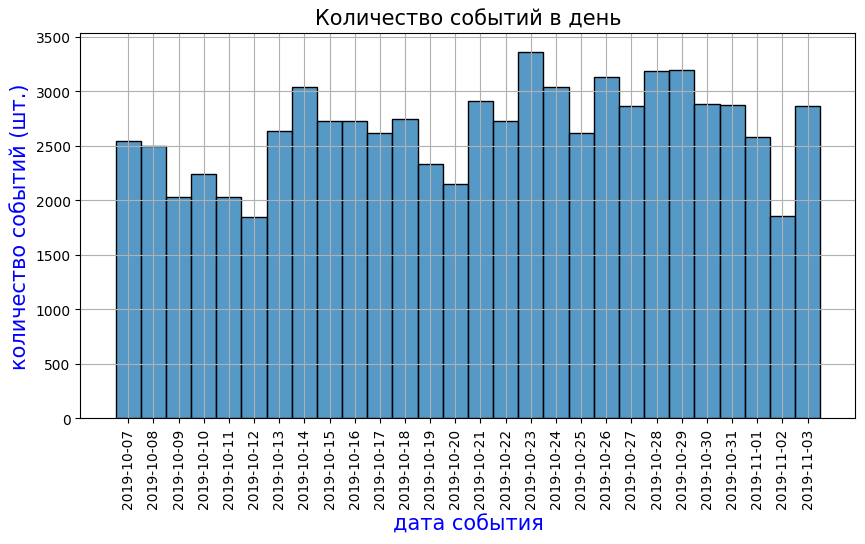

In [22]:
plt.figure(figsize=(10, 5))

sns.histplot(logs['event_dt'])

plt.grid()
plt.xlabel('дата события', fontsize=15, color='blue')
plt.ylabel('количество событий (шт.)', fontsize=15, color='blue')
plt.xticks(ticks=logs['event_dt'].unique(), rotation=90, fontsize=10)
plt.title('Количество событий в день', fontsize=15);

**Данные за весь период с 2019-10-07 по 2019-11-03 однородны по наполненности, будем использовать для анализа данные за весь период**

### Выделим сессии пользователей

Выделим сессии пользователя, примем одну сессию равной календарному дню. Данная информация понадобить для исследования воронки событий

In [23]:
session = (logs.groupby(['user_id', 'event_dt']).agg(
            {
                'event_name': 'unique',
                'event_time': ['min', 'max']
            }
        )
        .reset_index()
          )
session['event_name'] = session['event_name'].astype('string')
session = session.drop_duplicates().reset_index(drop=True)
session.columns = ['user_id', 'session_dt', 'script', 'session_start', 'session_end']
session['session_duration'] = (((session['session_end'] - session['session_start']).astype('timedelta64[s]')) / 60).round(1)
session['session_week'] = session['session_dt'].dt.isocalendar().week

session.head()

,user_id,session_dt,script,session_start,session_end,session_duration,session_week
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,['tips_show'],2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,9.9,41
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,['map' 'tips_show'],2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,8.4,41
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,['tips_show' 'map'],2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,15.0,43
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,['map' 'tips_show'],2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,12.6,43
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,['search' 'photos_show'],2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,25.3,42


### Создадим профили пользователей

In [24]:
profiles = (
    logs.groupby('user_id').agg(
      {
          'source': 'first',
          'event_name': ['count', 'unique'],
          'event_dt': 'nunique'
      }
    )
    .reset_index()   
)
profiles.columns = ['user_id', 'source', 'event_count', 'event_unique', 'session_count']
profiles['event_unique'] = profiles['event_unique'].astype('string')
profiles['is_contact_show'] = profiles['event_unique'].apply(lambda x: True if 'contacts_show' in x else False)
profiles = profiles.merge(
    session.groupby('user_id')['session_duration'].mean().reset_index()
    .rename(columns={'session_duration': 'avg_session'}),
    on='user_id',
    how='left'
)

profiles.head()

,user_id,source,event_count,event_unique,session_count,is_contact_show,avg_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,35,['tips_show' 'map'],4,False,11.475000
1,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,71,['search' 'photos_show' 'favorites_add' 'conta...,6,True,32.683333
2,00463033-5717-4bf1-91b4-09183923b9df,yandex,10,['photos_show'],1,False,24.700000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,32,['search' 'map' 'tips_show' 'advert_open'],6,False,215.583333
4,00551e79-152e-4441-9cf7-565d7eb04090,yandex,8,['contacts_show' 'contacts_call' 'search' 'pho...,3,True,3.100000


### Расчитаем метрики пользовательской активности (DAU, WAU, Sticky factor, Среднее число сессий на пользователя)

Посчитаем **DAU и WAU**. Сгруппируем данные по дате и неделе, посчитаем количество уникальных пользователей по столбцу `user_id` и найдём среднее

In [25]:
dau_total = (
    session.groupby('session_dt').agg({'user_id': 'nunique'}).reset_index()
)

wau_total = (
    session.groupby(['session_week']).agg({'user_id': 'nunique'}).reset_index()
)
wau_total['session_week'] = wau_total['session_week'].astype('string')

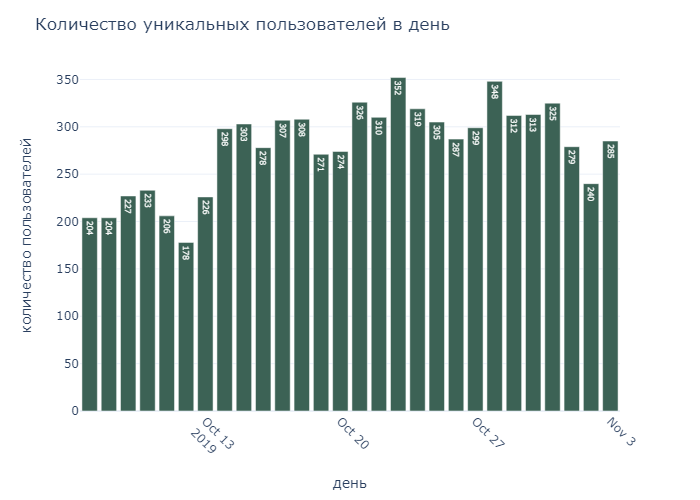

среднее количество пользователей в день: 279.0


In [26]:
fig = px.bar(dau_total, x='session_dt', y='user_id', text='user_id')
fig.update_layout(title='Количество уникальных пользователей в день',
                   xaxis_title='день',
                   yaxis_title='количество пользователей')
fig.update_xaxes(tickangle=45)
fig.show()
print('среднее количество пользователей в день:', (dau_total['user_id'].mean()).round())

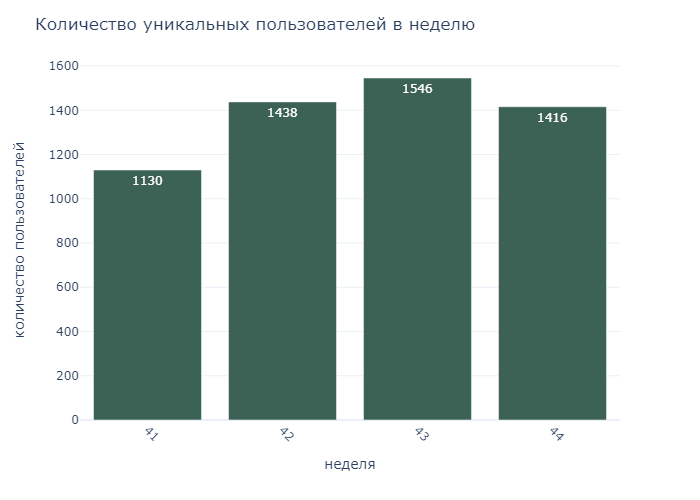

среднее количество пользователей в неделю: 1382.0


In [27]:
fig = px.bar(wau_total, x='session_week', y='user_id', text='user_id')
fig.update_layout(title='Количество уникальных пользователей в неделю',
                   xaxis_title='неделя',
                   yaxis_title='количество пользователей')
fig.update_xaxes(tickangle=45)
fig.show()
print('среднее количество пользователей в неделю:', (wau_total['user_id'].mean()).round())

- **DAU**(количество уникальных пользователей в день) в среднем **279** пользователей
- **WAU**(количество уникальных пользователей в неделю) в среднем **1382** пользователя
- динамика в целом положительная, что должно хорошо сказываться на продукте

Найдем метрику **Sticky factor** отражает регулярность использования приложения и для недельной аудитории рассчитывается как DAU/WAU

In [28]:
print((dau_total['user_id'].mean() / wau_total['user_id'].mean() * 100).round(2))

20.19


- **Sticky factor - 20.19**

**Определим среднее число сессий на пользователя в месяц и неделю**

В нашем распоряжении данные с 2019-10-07 по 2019-11-03 (4 недели), поэтому среднее количество сессий на человека в месяц у нас:

In [29]:
profiles['session_count'].describe().reset_index()

,index,session_count
0,count,4293.000000
1,mean,1.820871
2,std,1.762537
3,min,1.000000
4,25%,1.000000
5,50%,1.000000
6,75%,2.000000
7,max,25.000000


- среднее число сессий на пользователя в месяц **1.8** сессии
- медианное число сессий на пользователя в месяц **1** сессия

**Среднее число сессий на человека в неделю**

In [30]:
sessions_per_user = session.groupby('session_week').agg(
    {'user_id': ['count', 'nunique']}
)
sessions_per_user.columns = ['n_sessions', 'n_users']
# делим число сессий на количество пользователей
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)

sessions_per_user

,n_sessions,n_users,sessions_per_user
session_week,,,
41,1478,1130,1.307965
42,2039,1438,1.417942
43,2198,1546,1.421734
44,2102,1416,1.484463


- среднее число сессий на человека в неделю от **1.3 до 1.48** сессии

**Определим медианную продолжительность сессии `MSL`**

In [31]:
profiles['avg_session'].median()

16.459999999999997

- медианная продолжительность сессии около **16.5 минут**, неплохой результат

### Изучим источники привлечения и определим каналы, из которых пришло больше всего пользователей. Построим таблицу, отражающую количество пользователей и долю для каждого канала привлечения

In [32]:
channels = (
    logs.groupby('source')['user_id'].nunique().to_frame()
    .rename(columns={'user_id': 'user_count'})
    .sort_values(by='user_count', ascending=False)
).reset_index()
channels['%'] = round(channels['user_count'] / logs['user_id'].nunique() * 100, 1)

channels

,source,user_count,%
0,yandex,1934,45.1
1,other,1230,28.7
2,google,1129,26.3


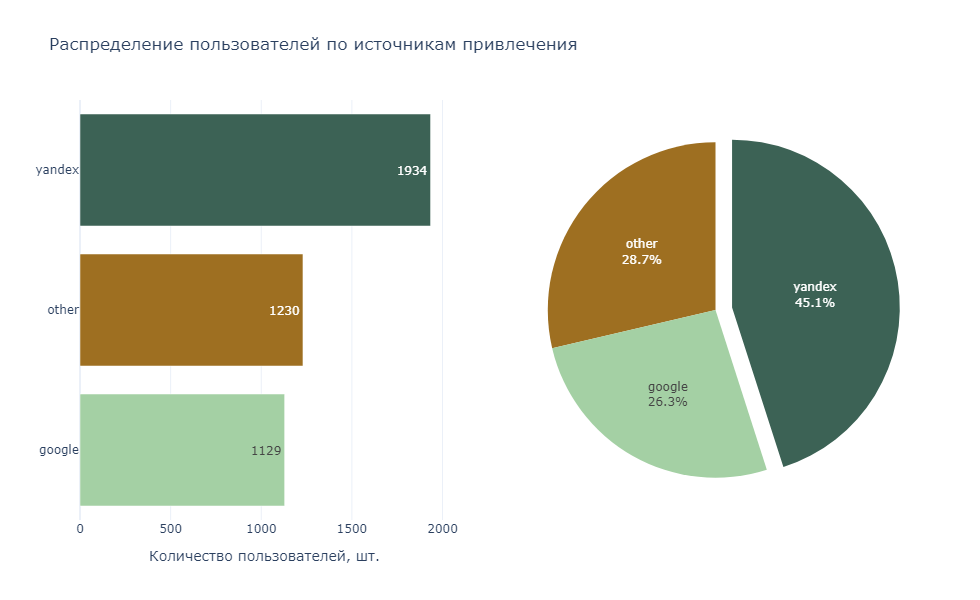

In [33]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'bar'}, {'type':'pie'}]])

fig.add_trace(go.Bar(x=channels['user_count'].sort_values(), y=channels.sort_values(by='user_count')['source'], orientation='h',
              text=channels['user_count'].sort_values(), marker=dict(color=bam_color[::-1])),
              row=1, col=1)

fig.add_trace(go.Pie(labels=channels['source'], values=channels['user_count'], pull = [0.1, 0]),
              row=1, col=2)

fig.update_traces(textposition='inside', textinfo='percent+label', row=1, col=2)
fig.update_xaxes(title='Количество пользователей, шт.' ,row=1, col=1)
fig.update_layout(title='Распределение пользователей по источникам привлечения',
                  width=980,
                  height=600, showlegend=False)

fig.show()

In [34]:
# определим свою цветовую гамму для графиков проекта
bam_color = ['#3C6255','#9E6F21', '#A4D0A4'] #, '#EAE7B1', '#CCD5AE', '#617A55', '#FEE8B0', '#B8E7E1']  # палитра цветов
pio.templates['bam'] = go.layout.Template(layout_colorway=bam_color)
pio.templates.default = "plotly_white+bam"

**Пользователи приходят в приложение из 3(трех) различных источников:**  
- на первом месте по количеству пользователей **yandex - 1934 (45.1%)** пользователей
- на втором месте **other - 1230 (28.7%)** пользователей
- на третьем месте **google - 1129 (26.3%)**
- заметно среди всех источников выделяется лидер **Yandex**, почти половина пользователей приходит с этого канала

---
### Вывод

**определили сколько всего событий в логе**
- всего **74197** событий в логе

**определили сколько всего пользователей в логе**
- всего **4293** пользователь в логе

**определили сколько в среднем событий приходится на пользователя**
- в среднем на пользователя приходится **17** событий
- медианное количество событий на пользователя **9**

**определили период данных, которыми мы располагаем**
- минимальная и максимальная даты привлечения пользователей **2019-10-07 и 2019-11-03**, соотвествуют датам из ТЗ

**построили гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период?**
- данные за весь период с **2019-10-07 по 2019-11-03** однородны по наполненности, будем использовать для анализа данные за весь период

**выделили сессии пользователей**
- приняли **одну сессию равной календарному дню**. Данная информация понадобить для исследования воронки событий

**создали профили пользователей**
- `user_id` - пользователи
- `source` - источник привлечения
- `event_count` - количество событий
- `event_unique` - список уникальных событий	
- `session_count` - количество сессий
- `is_contact_show` - маркер целевого события
- `avg_session` - средняя продолжительность сессии

**расчитаем метрики пользовательской активности**
- **DAU**(количество уникальных пользователей в день) **279** пользователей
- **WAU**(количество уникальных пользователей в неделю) **1382** пользователя
- динамика в целом положительная, что должно хорошо сказываться на продукте
- **Sticky factor - 20.19**
- среднее число сессий на пользователя в месяц **1.8** сессии
- медианное число сессий на пользователя в месяц **1** сессия
- среднее число сессий на человека в неделю от **1.3 до 1.48** сессии
- медианная продолжительность сессии около **16.5 минут**, неплохой результат

**изучили источники привлечения и определили каналы, из которых пришло больше всего пользователей. Построили таблицу, отражающую количество пользователей и долю для каждого канала привлечения**

**Пользователи приходят в приложение из 3(трех) различных источников:**  
- на первом месте по количеству пользователей **yandex - 1934 (45.1%)** пользователей
- на втором месте **other - 1230 (28.7%)** пользователей
- на третьем месте **google - 1129 (26.3%)**
- заметно среди всех источников выделяется лидер **Yandex**, почти половина пользователей приходит с этого канала
---

## Исследование воронки событий

### Выделим самые популярные сценарии, включающие целевое событие `contacts_show`

In [35]:
top_script = session[session['script'].str.contains('contacts_show')]['script'].value_counts().reset_index().head(15)
top_script

,index,script
0,['tips_show' 'contacts_show'],240
1,['contacts_show'],116
2,['map' 'tips_show' 'contacts_show'],85
3,['photos_show' 'contacts_show'],74
4,['contacts_show' 'contacts_call'],65
5,['contacts_show' 'tips_show'],46
6,['search' 'contacts_show' 'contacts_call'],42
7,['photos_show' 'contacts_show' 'contacts_call'],40
8,['search' 'photos_show' 'contacts_show'],40
9,['search' 'contacts_show'],40


- наиболее популярные сценарии
 - **tips_show -> contacts_show**
 - **map -> tips_show -> contacts_show**
 - **photos_show -> contacts_show**

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие. По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки

In [36]:
#интересующие нас события, входящие в популярные сценарии
event_list_1 = ['tips_show', 'contacts_show']
event_list_2 = ['map', 'tips_show', 'contacts_show']
event_list_3 = ['photos_show', 'contacts_show']

In [37]:
print('всего пользователей:', logs['user_id'].nunique())

всего пользователей: 4293


In [38]:
#фунция для:
#подсчета количество уникальных пользователей совершивших событие,
#подсчета конверсии 'в шаг',
#визуализация воронки событий 
def product_funnel_func(logs, event_list):
    #фильтруем датафрейм по пользователям, которые совершают первое событие
    users = logs[logs['event_name'] == event_list[0]]['user_id'].unique()
    
    # считаем количество уникальных пользователей совершивших событие из группы отфильтрованных пользователей
    events = (
        logs[logs['user_id'].isin(users)].groupby('event_name')['user_id'].nunique()
        .reset_index()
        .rename(columns={'user_id': 'user_count'})
    )
    events = events.query('event_name in @event_list').set_index('event_name')
    events['%'] = round(events['user_count'] /  len(users) * 100, 1)
    events = events.reindex(event_list).reset_index()
    display(events)
    
    # считаем конверсию 'в шаг'
    events['conversion, %'] = round(events['user_count'] / events['user_count'].shift(1) * 100, 1)
    events.loc[0, 'conversion, %'] = 100
    events = events.drop(columns='%')
    display(events)
    
    #визуализируем воронку событий
    fig = go.Figure()
    fig.add_trace(go.Funnel(x=events['conversion, %'], y=events['event_name']))
    fig.update_layout(
        title={
            'text': "Продуктовая воронка",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="событие",
    )
    fig.show()

**Рассмотрим первый (самый популярный сценарий) `tips_show -> contacts_show`**

,event_name,user_count,%
0,tips_show,2801,100.0
1,contacts_show,516,18.4


,event_name,user_count,"conversion, %"
0,tips_show,2801,100.0
1,contacts_show,516,18.4


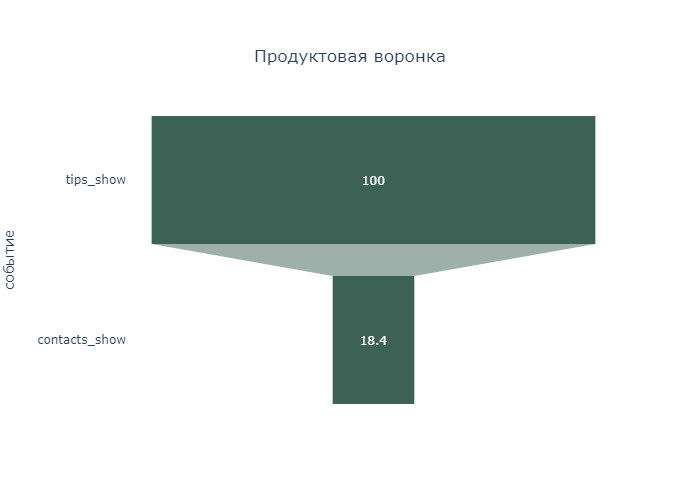

In [39]:
product_funnel_func(logs, event_list_1)

- пользователи, учавствующие в событии **tips_show - 2801 пользователей (100%)**
- делее идет событие **contacts_show - 516 пользователей (18.4%)**
- конверсия в шаг выглядит следующим образом:
 - **tips_show** - 2801 пользователей **100%** конверсии в шаг
 - **contacts_show** - 516 пользователей **18.4%** конверсии в шаг
- наблюдаем большую просадку в этом сценарии между шагами `tips_show -> contacts_show` - **теряем 81.6% пользователей**

**Рассмотрим второй сценарий `map -> tips_show -> contacts_show`**

,event_name,user_count,%
0,map,1456,100.0
1,tips_show,1352,92.9
2,contacts_show,289,19.8


,event_name,user_count,"conversion, %"
0,map,1456,100.0
1,tips_show,1352,92.9
2,contacts_show,289,21.4


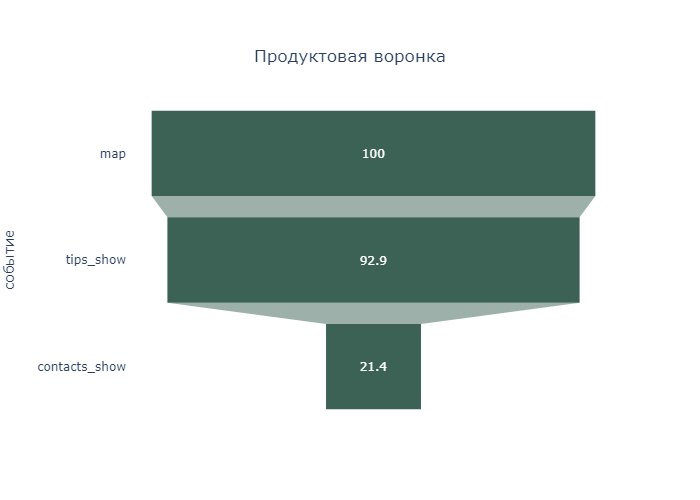

In [40]:
product_funnel_func(logs, event_list_2)

- пользователи, учавствующие в событии **map - 1456 пользователей (100%)**
- далее идет событие **tips_show - 1352 (92.9%)**
- делее идет событие **contacts_show - 289 (19.8%)**
- конверсия в шаг выглядит следующим образом:
 - **map** - 1456 пользователей **100%** конверсии в шаг
 - **tips_show** - 1352 пользователей **92.9%** конверсии в шаг
 - **contacts_show** - 289 пользователей **21.4%** конверсии в шаг
- наблюдаем большую просадку в этом сценарии между шагами `tips_show -> contacts_show` - теряем **78.6%** пользователей

**Рассмотрим третий популярный сценарий `photos_show -> contacts_show`**

,event_name,user_count,%
0,photos_show,1095,100.0
1,contacts_show,339,31.0


,event_name,user_count,"conversion, %"
0,photos_show,1095,100.0
1,contacts_show,339,31.0


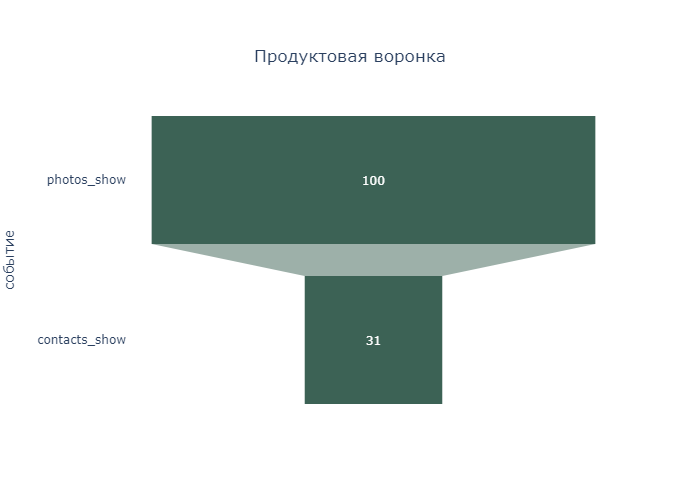

In [41]:
product_funnel_func(logs, event_list_3)

- пользователи, учавствующие в событии **photos_show - 1095 пользователей (100%)**
- далее идет событие **contacts_show - 339 (31.0%)**
- конверсия в шаг выглядит следующим образом:
 - **photos_show** - 1095 пользователей **100%** конверсии в шаг
 - **contacts_show** - 339 пользователей **31.0%** конверсии в шаг
- наблюдаем большую просадку в этом сценарии между шагами `photos_show -> contacts_show` - **теряем 69% пользователей**

### Выделим сессии где есть поиск и открытие объявления и выясним как различается время между поиском и открытием объявления у пользователей, совершающих и не совершающих целевое действие

In [42]:
#выделим логи с интересующими нас действиями
session_search_and_advertopen = (
    logs.rename(columns={'event_dt': 'session_dt'})
        .query('event_name == "search" or event_name == "advert_open"')
    
)
#сведем таблицу по пользователям, сессии и событию, 
#оставим первое время повторяющихся событий
session_search_and_advertopen = (
    session_search_and_advertopen
    .pivot_table(index=['user_id', 'session_dt'], columns='event_name', values='event_time', aggfunc='first')
    .dropna()
)
#вычислим время между поиском и открытием объявления
#удалим отрицательные значения
session_search_and_advertopen['time_delta'] = (
    ((session_search_and_advertopen['advert_open'] - session_search_and_advertopen['search']).astype('timedelta64[s]')) / 60
).round(1)
session_search_and_advertopen = (
    session_search_and_advertopen[session_search_and_advertopen['time_delta'] > 0]
    .reset_index()
)
#добавим признак совершения целевого действия
session_search_and_advertopen = (
    session_search_and_advertopen
    .merge(profiles[['user_id', 'is_contact_show']], on='user_id', how='left')
)

session_search_and_advertopen.head()

,user_id,session_dt,advert_open,search,time_delta,is_contact_show
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29,2019-10-29 22:10:21.561467,2019-10-29 21:18:24.850073,51.9,True
1,0164902d-7393-47e1-9d5b-0ec4c0171cdc,2019-10-28,2019-10-28 15:16:57.266458,2019-10-28 15:16:28.675257,0.5,False
2,017c6afc-965d-4c94-84ee-f0e326998e30,2019-10-10,2019-10-10 14:29:11.294613,2019-10-10 14:28:16.556947,0.9,False
3,02e7c193-842b-4995-b67a-8c87ac0f29bb,2019-10-08,2019-10-08 20:43:46.668606,2019-10-08 20:41:11.253131,2.6,False
4,04adf25e-cb60-4cbd-bedc-ddc1057cde06,2019-10-13,2019-10-13 15:43:48.511617,2019-10-13 15:41:09.088066,2.6,True


**Все сессии, в которых есть поиск и открытие объявления разделены следующим образом**

In [43]:
session_search_and_advertopen.groupby('is_contact_show')['session_dt'].count().reset_index()

,is_contact_show,session_dt
0,False,223
1,True,85


- сессий у пользователей не просматривающих контакты - **223**
- сессий у пользователей просматривающих контакты - **85**

**Сгруппируем данные по признаку целевого действия `contact_show` и определим медианное время между поиском и открытием объявления эти групп**

In [44]:
print('Медианное время между поиском и открытием объявления\n'
      + 'у пользователей совершивших целевое событие:',
    session_search_and_advertopen.query('is_contact_show == True')['time_delta'].median()
)
print('Медианное время между поиском и открытием объявления\n'
      + 'у пользователей не совершивших целевое событие:',
    session_search_and_advertopen.query('is_contact_show == False')['time_delta'].median()
)

Медианное время между поиском и открытием объявления
у пользователей совершивших целевое событие: 3.7
Медианное время между поиском и открытием объявления
у пользователей не совершивших целевое событие: 1.9


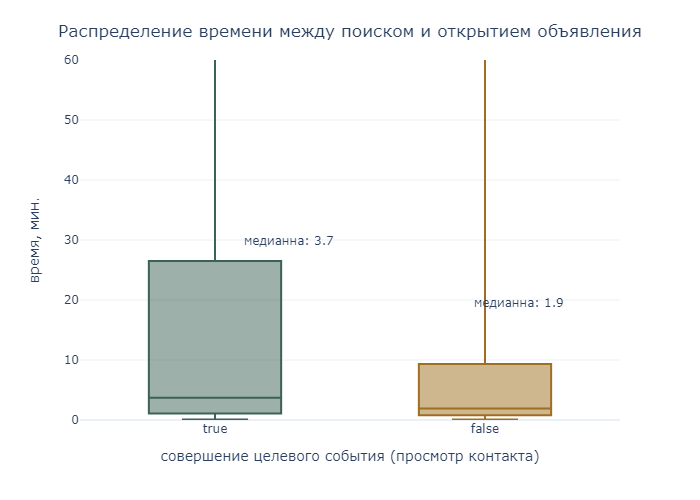

In [57]:
fig = px.box(session_search_and_advertopen, y='time_delta', x='is_contact_show', color='is_contact_show', 
             points=False
            )
fig.update_layout(
        title={
            'text': "Распределение времени между поиском и открытием объявления",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="совершение целевого события (просмотр контакта)",
        yaxis_title="время, мин.",
        showlegend=False,
        
    )
fig.add_annotation(
    text=('медианна: '+str(session_search_and_advertopen.query('is_contact_show == True')['time_delta'].median())),
    xref="paper", yref="paper",
    x=0.3, y=0.5, showarrow=False)
fig.add_annotation(
    text=('медианна: '+str(session_search_and_advertopen.query('is_contact_show == False')['time_delta'].median())),
    xref="paper", yref="paper",
    x=0.90, y=0.3, showarrow=False)
fig.update_yaxes(range=[0, 60])

fig.show()

медианное время сессии, в которой присутствует поиск и открытие объявления
- у пользователей **совершивших** целевое событие: **3.7 минут**
- у пользователей **не совершивших** целевое событие: **1.9 минут**
- время между поиском и открытием объявления у пользователей совершивших целевое событие в **2 раза больше**, чем у пользователей, не совершивших целевое событие

---
### Вывод

**выделили самые популярные сценарии, включающие целевое событие `contacts_show`**
- наиболее популярные сценарии
 - **tips_show -> contacts_show**
 - **map -> tips_show -> contacts_show**
 - **photos_show -> contacts_show**
 
**посчитали, сколько пользователей совершали каждое из этих событий. Отсортировали события по числу пользователей. Посчитали долю пользователей, которые хоть раз совершали событие. По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки**
- **рассмотрели первый (самый популярный сценарий) `tips_show -> contacts_show`**
 - пользователи, учавствующие в событии **tips_show - 2801 пользователей (100%)**
 - делее идет событие **contacts_show - 516 пользователей (18.4%)**
 - конверсия в шаг выглядит следующим образом:
  -- **tips_show** - 2801 пользователей **100%** конверсии в шаг
  -- **contacts_show** - 516 пользователей **18.4%** конверсии в шаг
 - наблюдаем большую просадку в этом сценарии между шагами `tips_show -> contacts_show` - **теряем 81.6% пользователей**
- **рассмотрели второй сценарий `map -> tips_show -> contacts_show`**
 - пользователи, учавствующие в событии **map - 1456 пользователей (100%)**
 - далее идет событие **tips_show - 1352 (92.9%)**
 - делее идет событие **contacts_show - 289 (19.8%)**
 - конверсия в шаг выглядит следующим образом:
  -- **map** - 1456 пользователей **100%** конверсии в шаг
  -- **tips_show** - 1352 пользователей **92.9%** конверсии в шаг
  -- **contacts_show** - 289 пользователей **21.4%** конверсии в шаг
- наблюдаем большую просадку в этом сценарии между шагами `tips_show -> contacts_show` - теряем **78.6%** пользователей
- **рассмотрели третий популярный сценарий `photos_show -> contacts_show`**
 - пользователи, учавствующие в событии **photos_show - 1095 пользователей (100%)**
 - далее идет событие **contacts_show - 339 (31.0%)**
 - конверсия в шаг выглядит следующим образом:
  -- **photos_show** - 1095 пользователей **100%** конверсии в шаг
  -- **contacts_show** - 339 пользователей **31.0%** конверсии в шаг
 - наблюдаем большую просадку в этом сценарии между шагами `photos_show -> contacts_show` - **теряем 69% пользователей**
 
**выделили сессии где есть поиск и открытие объявления и выяснили как различается время между поиском и открытием объявления у пользователей, совершающих и не совершающих целевое действие**
- все сессии, в которых есть поиск и открытие объявления разделены следующим образом
 - сессий у пользователей не просматривающих контакты - **223**
 - сессий у пользователей просматривающих контакты - **85**
- сгруппировали данные по признаку целевого действия `contact_show` и определили медианное время сессии эти групп
 - медианное время сессии, в которой присутствует поиск и открытие объявления
 -- у пользователей **совершивших** целевое событие: **3.7 минут**
 -- у пользователей **не совершивших** целевое событие: **1.9 минут**
 -- время между поиском и открытием объявления у пользователей совершивших целевое событие в **2 раза больше**, чем у пользователей, не совершивших целевое событие

---

## Статистическая проверка гипотез

### Одни пользователи совершают действия `tips_show` и `tips_click`, другие — только `tips_show`. Проверить гипотезу: конверсия в просмотры контактов различается у этих двух групп

***Сформируем гипотезы:***

**H_0:** Конверсия в просмотры контактов пользователей, совершающих действия `tips_show` и `tips_click` = Конверсии в просмотры контактов пользователей, совершающих только `tips_show`

**H_a:** Конверсия в просмотры контактов пользователей, совершающих действия `tips_show` и `tips_click` ≠ Конверсии в просмотры контактов пользователей, совершающих только `tips_show`

**alpha = 0.05**

**Выделим две группы пользователей**
- первая группа A, совершают действие `tips_show`, `tips_click`
- вторая группа B, совершают действие `tips_show` без `tips_click`

In [46]:
user_id_group_A = (
    profiles[(profiles['event_unique'].str.contains('tips_show')) 
            & (profiles['event_unique'].str.contains('tips_click'))
            ][['user_id']].reset_index(drop=True)
)
user_id_group_A['group'] = 'A'

print('всего пользователей в группе А:', len(user_id_group_A))
user_id_group_A.head()

всего пользователей в группе А: 297


,user_id,group
0,01147bf8-cd48-49c0-a5af-3f6eb45f8262,A
1,01b4ca51-930d-4518-aa09-8a8c35e1d9cc,A
2,02e7c193-842b-4995-b67a-8c87ac0f29bb,A
3,04ee0c31-3c77-49f8-81d2-bbfe9fe2cde8,A
4,0656a1d1-9032-43ae-b936-11e41526eeff,A


In [47]:
user_id_group_B = (
    profiles[(profiles['event_unique'].str.contains('tips_show')) 
            & ~(profiles['event_unique'].str.contains('tips_click'))
            ][['user_id']].reset_index(drop=True)
)
user_id_group_B['group'] = 'B'

print('всего пользователей в группе B:', len(user_id_group_B))
user_id_group_B.head()

всего пользователей в группе B: 2504


,user_id,group
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,B
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,B
2,00554293-7e00-4122-b898-4e892c4a7c53,B
3,005fbea5-2678-406f-88a6-fbe9787e2268,B
4,007d031d-5018-4e02-b7ee-72a30609173f,B


Проверим нет ли пересекающихся пользователей между двумя группами

In [48]:
user_id_group_A[user_id_group_A['user_id'].isin(user_id_group_B['user_id'])]

,user_id,group


**Пересекающихся пользователей нет**

**Объединим две таблицы в одну**

In [49]:
user_id_group_A_B = pd.concat([user_id_group_A, user_id_group_B], axis=0, ignore_index=True)

**Создадим новый файл `new_logs`, где будут присутствовать только пользователи из группы А и группы B**

In [50]:
new_logs = logs.merge(user_id_group_A_B, on='user_id')

new_logs.head()

,event_time,event_name,user_id,source,event_dt,group
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,B
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,B
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,B
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,B
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,B


**Посчитаем конверсию этих двух групп**

Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию)

In [51]:
def a_b_stats(data, group_1, group_2, alpha=0.05):   # функция для подсчета стат. значимости долей
    g_1 = ( 
        data[data['group'] == group_1]
        .groupby('event_name')['user_id'].nunique()
        .sort_values(ascending=False).reset_index()
    )
    g_1['all_users'] = data[data['group'] == group_1]['user_id'].nunique()
    
    g_2 = ( 
        data[data['group'] == group_2]
        .groupby('event_name')['user_id'].nunique()
        .sort_values(ascending=False).reset_index()
    )
    g_2['all_users'] = data[data['group'] == group_2]['user_id'].nunique()
    
    g_g2_table = g_1.merge(g_2, on='event_name', suffixes=('_' + str(group_1), '_' + str(group_2)))
    
    # пропорция успехов в первой группе
    g_g2_table['p1'] = (g_g2_table['user_id_' + str(group_1)] / g_g2_table['all_users_' + str(group_1)]).round(3)
    # пропорция успехов во второй группе
    g_g2_table['p2'] = (g_g2_table['user_id_' + str(group_2)] / g_g2_table['all_users_' + str(group_2)]).round(3)
    # пропорция успехов в комбинированном датасете
    g_g2_table['p_combined'] = (
        (g_g2_table['user_id_' + str(group_1)] + g_g2_table['user_id_' + str(group_2)]) 
        / (g_g2_table['all_users_' + str(group_1)] + g_g2_table['all_users_' + str(group_2)])
    ).round(3)
    # разница пропорций в датасетах
    g_g2_table['difference'] = g_g2_table['p1'] - g_g2_table['p2']
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    g_g2_table['z_value'] = (
        g_g2_table['difference']
        / np.sqrt(
            g_g2_table['p_combined'] 
            * (1 - g_g2_table['p_combined']) 
            * (1 / g_g2_table['all_users_' + str(group_1)] + 1 / g_g2_table['all_users_' + str(group_2)])
        )

    ).round(3)
    
    distr = st.norm(0, 1) # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

    # Если бы пропорции были равны, разница между ними была бы равна нулю 
    # Посчитаем, как далеко статистика уехала от нуля
    # Какова вероятность получить такое отличие или больше? 
    # Так как распределение статистики нормальное, вызовем метод cdf()
    # Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака
    # Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат

    g_g2_table['p_value'] = ((1 - distr.cdf(abs(g_g2_table['z_value']))) * 2).round(3)
    g_g2_table['result'] = g_g2_table['p_value'].map(
        lambda x: 'есть значимая разница между долями' if x < alpha else 'нет значимой разницы между долями'
    ) 
      
    return g_g2_table  

**Проверим, будет ли отличие между группами A и B статистически значимым**

In [52]:
a_b_stats(new_logs, 'A', 'B').query('event_name == "contacts_show"').reset_index(drop=True)

,event_name,user_id_A,all_users_A,user_id_B,all_users_B,p1,p2,p_combined,difference,z_value,p_value,result
0,contacts_show,91,297,425,2504,0.306,0.17,0.184,0.136,5.719,0.0,есть значимая разница между долями


- **Значение p-value показывает: вероятность случайно получить такое или большее различие 0%. Это достаточная вероятность, чтобы делать вывод о значимом различии конверсии между группами.**
- **Полученные данные противоречат нулевой гипотезе о том, что `Конверсия в просмотры контактов пользователей, совершающих действия tips_show и tips_click = Конверсии в просмотры контактов пользователей, совершающих только tips_show`**
- **Поэтому у нас есть основания отбросить нулевую гипотезу и принять гипотезу о том, что конверсия отличается**
- **конверсия группы пользователей совершающих действия tips_show и tips_click в просмотры контактов - `30.6%`**
- **конверсия группы пользователей совершающих только tips_show в просмотры контактов - `17%`**
- **конверсия группы А в `1.8` раза выше группы В**

### Средняя продолжительность сессии пользователей совершающие целевое действие отличается от средней сессии пользователей не совершивших целевое действие

***Сформируем гипотезы:***

**H_0:** Средняя продолжительность сессии пользователей совершающие целевое действие `contacts_show` = Средней продолжительность сессии пользователей не совершающих целевое действие `contacts_show`

**H_a:** Средняя продолжительность сессии пользователей совершающие целевое действие `contacts_show` ≠ Средней продолжительность сессии пользователей не совершающих целевое действие `contacts_show`

**alpha = 0.05**

In [53]:
profiles.head()

,user_id,source,event_count,event_unique,session_count,is_contact_show,avg_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,35,['tips_show' 'map'],4,False,11.475000
1,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,71,['search' 'photos_show' 'favorites_add' 'conta...,6,True,32.683333
2,00463033-5717-4bf1-91b4-09183923b9df,yandex,10,['photos_show'],1,False,24.700000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,32,['search' 'map' 'tips_show' 'advert_open'],6,False,215.583333
4,00551e79-152e-4441-9cf7-565d7eb04090,yandex,8,['contacts_show' 'contacts_call' 'search' 'pho...,3,True,3.100000


**Посчитаем 95-й и 99-й перцентили средней сессии пользователей. Выберем границу для определения аномальных значений**

In [54]:
print(np.percentile(profiles['avg_session'], [95, 99]))

[287.79  654.912]


- не более **5%** сессий дольше **288 минут**
- не более **1%** сессий дольше **655 минут**
- примем за аномальных пользователей тех, у кого средняя сессия **длиннее 287 минут**. Так мы уберём **5%** пользователей с наиболее длинными сессиями

**Удалим пользователей с аномально длинными сессиями и разделим данные на две группы**

In [55]:
clear_profiles = profiles[profiles['avg_session'] < (int(np.percentile(profiles['avg_session'], [95])))]

group_contact_show = clear_profiles[clear_profiles['is_contact_show'] == True]['avg_session']
group_contact_NO_show = clear_profiles[clear_profiles['is_contact_show'] == False]['avg_session']

**Применим статистический критерий Манна-Уитни к полученным выборкам**

In [56]:
print('p-value: {0:.3f}'.format(st.mannwhitneyu(group_contact_show, group_contact_NO_show)[1]))
print('относительный прирост: {0:.3f}'.format(group_contact_show.mean()/group_contact_NO_show.mean()-1))

p-value: 0.000
относительный прирост: 0.797


- критический уровень статистической значимости мы приняли **5%** - это является общепринятым пороговым значением
- значение p-value показывает: вероятность случайно получить такое или большее различие **0%**. Это достаточная вероятность, чтобы делать вывод о значимом различии
- полученные данные противоречат нулевой гипотезе о том, что различий в средней сессии посетителя между группами нет, поэтому у нас есть основания отбросить нулевую гипотезу и принять гипотезу о том, что различия есть
- p-значение **0.000 < 0.05** (критический уровень статистической значимости)
- **отвергаем нулевую гипотезу: разница статистически значима**
- **по «очищенным» данным можем предположить что различия в средней длинне сессии на посетителя между группами есть**
- относительный выигрыш группы, которая просматривает контакты равен **79.7%**

---
### Вывод

**одни пользователи совершают действия `tips_show` и `tips_click`, другие — только `tips_show`. Проверили гипотезу: конверсия в просмотры контактов различается у этих двух групп**
- ***Сформировали гипотезы:***
 - **H_0:** Конверсия в просмотры контактов пользователей, совершающих действия `tips_show` и `tips_click` = Конверсии в просмотры контактов пользователей, совершающих только `tips_show`
 - **H_a:** Конверсия в просмотры контактов пользователей, совершающих действия `tips_show` и `tips_click` ≠ Конверсии в просмотры контактов пользователей, совершающих только `tips_show`
 - **alpha = 0.05**
- **выделили две группы пользователей**
 - первая группа A, совершают действие `tips_show`, `tips_click`- всего пользователей в группе **А: 297**
 - вторая группа B, совершают действие `tips_show` без `tips_click` - всего пользователей в группе **B: 2504**
- объединили две таблицы в одну
- создали новый файл `new_logs`, где присутствовать только пользователи из группы А и группы B
- посчитали конверсию этих двух групп
- проверили, будет ли отличие между группами A и B статистически значимым
- **Значение p-value показывает: вероятность случайно получить такое или большее различие 0%. Это достаточная вероятность, чтобы делать вывод о значимом различии конверсии между группами.**
- **Полученные данные противоречат нулевой гипотезе о том, что `Конверсия в просмотры контактов пользователей, совершающих действия tips_show и tips_click = Конверсии в просмотры контактов пользователей, совершающих только tips_show`**
- **Поэтому у нас есть основания отбросить нулевую гипотезу и принять гипотезу о том, что конверсия отличается**
- **конверсия группы пользователей совершающих действия tips_show и tips_click в просмотры контактов - `30.6%`**
- **конверсия группы пользователей совершающих только tips_show в просмотры контактов - `17%`**
- **конверсия группы А в `1.8` раза выше группы В**

**средняя продолжительность сессии пользователей совершающие целевое действие отличается от средней сессии пользователей не совершивших целевое действие**
- ***Сформировали гипотезы:***
 - **H_0:** Средняя продолжительность сессии пользователей совершающие целевое действие `contacts_show` = Средней продолжительность сессии пользователей не совершающих целевое действие `contacts_show`
 - **H_a:** Средняя продолжительность сессии пользователей совершающие целевое действие `contacts_show` ≠ Средней продолжительность сессии пользователей не совершающих целевое действие `contacts_show`
 - **alpha = 0.05**
- посчитали 95-й и 99-й перцентили средней сессии пользователей. Выбрали границу для определения аномальных значений
 - не более **5%** сессий дольше **288 минут**
 - не более **1%** сессий дольше **655 минут**
 - приняли за аномальных пользователей тех, у кого средняя сессия **длиннее 287 минут**. Так мы уберём **5%** пользователей с наиболее длинными сессиями
- удалили пользователей с аномально длинными сессиями и разделили данные на две группы
- применили статистический критерий **Манна-Уитни** к полученным выборкам
 - критический уровень статистической значимости мы приняли **5%** - это является общепринятым пороговым значением
 - значение p-value показывает: вероятность случайно получить такое или большее различие **0%**. Это достаточная вероятность, чтобы делать вывод о значимом различии
 - полученные данные противоречат нулевой гипотезе о том, что различий в средней сессии посетителя между группами нет, поэтому у нас есть основания отбросить нулевую гипотезу и принять гипотезу о том, что различия есть
 - p-значение **0.000 < 0.05** (критический уровень статистической значимости)
 - **отвергаем нулевую гипотезу: разница статистически значима**
 - **по «очищенным» данным можем предположить что различия в средней длинне сессии на посетителя между группами есть**
 - относительный выигрыш группы, которая просматривает контакты равен **79.7%**
---

## Общий вывод

# Исследование поведения пользователей в мобильном приложении 
# "Ненужные вещи"
**Описание проекта**

Отделу аналитики приложения "Ненужные вещи" поступила задача от продукт-менеджера. Необходимо понять аудиторию приложения, сегментировать пользователей, для этого нам предстоит пронализировать поведение пользователей,- мы должны понять аудиторию, понять сценарии использования приложения

**Цель исследования**
- понять аудиторию приложения,- мы должны понять аудиторию, понять сценарии использования приложения для последующей сегментации пользователей, для этого нам предстоит пронализировать поведение пользователей

**В наличии есть следующие данные**

- `mobile_dataset.csv` - датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений. В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года
- `mobile_sources.csv` - датасет с источниками, с которых пользователь установил приложение

**Задачи исследования**

- выяснить какие сценарии использования приложения выделяются
- проанализировать связь целевого события — просмотра контактов — и других действий пользователей
- выяснить как различается время между поиском и открытием объявления у пользователей, совершающих и не совершающих целевое действие
- проверить статистические гипотезы
 - одни пользователи совершают действия tips_show и tips_click, другие — только tips_show. Проверить гипотезу: конверсия в просмотры контактов различается у этих двух групп
 - пользователи совершающие целевое действие являются более вовлеченными в приложение
 
**Ход исследования**

1. Загрузить файлы с данными и выполнить обзор данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Исследование воронки событий
5. Статистическая проверка гипотез
6. Общий вывод
---

**общая информация по данным**
- всего **74197** событий в логе
- всего **4293** пользователь в логе
- в среднем на пользователя приходится **17** событий
- медианное количество событий на пользователя **9**
- минимальная и максимальная даты привлечения пользователей **2019-10-07 и 2019-11-03**
- приняли **одну сессию равной календарному дню**

**основные метрики пользовательской активности**
- **DAU**(количество уникальных пользователей в день)в среднем **279** пользователей
- **WAU**(количество уникальных пользователей в неделю)в среднем **1382** пользователя
- динамика в целом положительная, что должно хорошо сказываться на продукте
- **Sticky factor - 20.19**
- среднее число сессий на пользователя в месяц **1.8** сессии
- медианное число сессий на пользователя в месяц **1** сессия
- среднее число сессий на человека в неделю от **1.3 до 1.48** сессии
- медианная продолжительность сессии около **16.5 минут**, неплохой результат

**пользователи приходят в приложение из 3(трех) различных источников:**  
- на первом месте по количеству пользователей **yandex - 1934 (45.1%)** пользователей
- на втором месте **other - 1230 (28.7%)** пользователей
- на третьем месте **google - 1129 (26.3%)**
- заметно среди всех источников выделяется лидер **Yandex**, почти половина пользователей приходит с этого канала
---

**исследование продуктовой воронки**

самые популярные сценарии, включающие целевое событие `contacts_show`
- **tips_show -> contacts_show**
 - конверсия в шаг выглядит следующим образом:
  -- **tips_show** - 2801 пользователей **100%** конверсии в шаг
  -- **contacts_show** - 516 пользователей **18.4%** конверсии в шаг
  -- наблюдаем большую просадку в этом сценарии между шагами `tips_show -> contacts_show` - **теряем 81.6% пользователей**
- **map -> tips_show -> contacts_show**
 - конверсия в шаг выглядит следующим образом:
  -- **map** - 1456 пользователей **100%** конверсии в шаг
  -- **tips_show** - 1352 пользователей **92.9%** конверсии в шаг
  -- **contacts_show** - 289 пользователей **21.4%** конверсии в шаг
  -- наблюдаем большую просадку в этом сценарии между шагами `tips_show -> contacts_show` - **теряем 78.6% пользователей**
- **photos_show -> contacts_show**
 - конверсия в шаг выглядит следующим образом:
  -- **photos_show** - 1095 пользователей **100%** конверсии в шаг
  -- **contacts_show** - 339 пользователей **31.0%** конверсии в шаг
  -- наблюдаем большую просадку в этом сценарии между шагами `photos_show -> contacts_show` - **теряем 69% пользователей**
- **медианное время сессии, в которой присутствует поиск и открытие объявления**
 - у пользователей **совершивших** просмотр контактов: **3.7 минут**
 - у пользователей **не совершивших** просмотр контактов: **1.9 минут**
 - время между поиском и открытием объявления у пользователей совершивших целевое событие в **2 раза больше**, чем у пользователей, не совершивших целевое событие
---

**статистическое исследование**
- сравнение конверсии группы пользователей совершающих действия `tips_show и tips_click` и совершающий только `tips_show` в просмотры контактов
 - **стат исследование показало, что конверсия отличается**
 - конверсия группы пользователей совершающих действия `tips_show и tips_click` в просмотры контактов - **30.6%**
 - конверсия группы пользователей совершающих только `tips_show` в просмотры контактов - **17%**
 - **конверсия группы А в `1.8` раза выше группы В**
 
- сравнение средней продолжительности сессии пользователей **совершающие просмотр контактов** и не **совершивших просмотр контактов**
 - **стат исследование показало, что среднее время сессии групп пользователей отличается**
 - относительное увеличение средней сессии группы, которая просматривает контакты равен **79.7%**
---

- **исследования показывают, что пользователи просматривающие контакты тратят намного больше времени между поиском и открытием объявления, так и среднее время сессии таких пользователей выше**
 - это может говорить о каких-то проблемах при использовании целевого дейтсвия - просмотр контактов
 - рекомендуется дополнительно проанализировать технические аспекты этого действия
- **большие потери конверсии при переходе на просмотр контактов**, так же свидетельствуют об этом
- наблюдаем также большое различие конверсии в просмотр контактов групп пользователей, которые только смотрят рекомендации и тех, кто смотри и переходит по ним
 - получается есть трудности при переходе в контакты сразу из рекомендательной ленты
 
- **рекомендуется повышать конверсию переходов на просмотр контактов**
- так же изучить страницу просмора контактов, возможно получиться ее оптимизировать,- изменить дизайн, сделать более понятной для пользователя, чтобы выровнить время сессии пользователей, а так же время между поиском и открытием объявления у тех кто смотрит контакты и тех, кто не смотрит